<h1><center>Airborne Infection Risk Calculator for Indoor Environments
</center></h1>

<center>By Etienne Doidic, Zhexu Li, and Nicholas Kho <center>

The global pandemic of COVID-19 has demonstrated the exceptional transmissibility of the SARS-CoV-2 virus and has highlighted the vulnerability of the built environment to airborne pathogens. For the past 40 years, Heat, Ventilation, and Air Conditioning (HVAC) systems in buildings have been optimized to recirculate conditioned air to save energy while maintaining a stable temperature [[Perez-Lombard et al. 2011]](https://doi.org/10.1016/j.enbuild.2010.10.025). However, HVAC systems operators must now consider the dangers of air recirculation and aim to prevent the buildup of airborne particles or pathogens throughout buildings in order to ensure the health of occupants and the greater public. As buildings today reopen without a vaccine it is important to understand the risk of airborne infection based on building and occupant features, for not only the current pandemic, but for future ones as well. One method that has been developed to address this problem is the infection risk calculator. These calculators allow users to input variables such as the number of occupants,  room dimensions, air change per hour (ACH), masks/no masks, etc., in order to determine the risk of infected person(s) transmitting a virus to susceptible people the room [Lelieveld et al. 2020](https://doi.org/10.3390/ijerph17218114).

While these calculators may be convenient in some cases, they are “black box” algorithms, meaning the underlying code is not accessible or transparent to users. With a large amount of skepticism surrounding the academic literature regarding this virus and its transmission [[Scheirer 2020]](https://doi.org/10.1080/00963402.2020.1778361), we believe it is important infection risk calculators are as transparent as possible. 

In this notebook we describe our methods for developing our own infection risk algorithm for the SARS-CoV-2 virus which accepts room data, and a set of parameters regarding occupants and infection rates of the surrounding community. Code and assumptions made in the algorithm will be clearly explained to users for transparency. 

In [1]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
sys_path = os.path.dirname(os.getcwd())
src_path = sys_path + "/src"

sys.path.insert(1, src_path)
from calculator import *
assumptions = var
src_path = sys_path + "/notebook"

sys.path.insert(1, src_path)


Here is where users can test out different parameters in order to get different results.
It has been a challenge thus far to aquire accurate building data so we are limited to the manually inputted dataset located in notebooks/data/room_data.csv' but hopefully this gives an idea about what kind of building data are accepted by this calculator.

In the future we hope to integrate this calculator with more automated systems of data retrieval such as real-time infection rates using web-mining, and querying building data directly from building systems using Brick and Metasys, for example.

The default example calculates the infection risk of a classroom of students in Center Hall 101, a building at UC San Diego.
This cell contains the only parameters that should be changed.

In [2]:
#--------User Parameters----------------
#Number of occupants
#Room ID
room_id = 'CENTER 101'
#50 occupants is the reduced COVID-19 capacity.
n_occupants = 50 
#Duration in room in hours
t = 1.25
#Activity
#For our experiment we will assume the occupants are resting (sitting)
activities = ['resting', 'light_exercise', 'moderate_exercise', 'heavy_exercise']
activity = activities[0]
    
#Vocal Activity 
#For our experiment we will assume the occupants are speaking.
expiratory_activities = ['speaking', 'whispering', 'singing', 'breathing']
expiratory_activity = expiratory_activities[0]

Read in data regarding our subject room on the UC San Diego campus.

In [5]:
room_dic = get_room_data(sys_path + '/data/raw/rm.csv', room_id)
room_dic

{'room_area': 3428,
 'room_hght': 21.0,
 'cfm_range': [3500, 7000],
 'windows': nan,
 'room_volume': 71988.0,
 'room_volume_m': 2038.4697984}

To calculate the risk of infection in a given room, the emmission rate of quanta is needed. A quantum is defined as the viral load i.e. the dose of contaminated airborne droplet nuclei required to cause infection in 63% of persons. 
The emmission rate of quanta is caclulated with the following formula:
![title](images/formula1.1.png)

[Morawska et al. 2020](https://doi.org/10.1016/j.envint.2020.105794)

<b>cv</b> corresponds to the <b>viral load in the sputum</b> (i.e. infectious mucus) of the infected person, expressed in <b>RNA copies per mililiter</b>. The viral load in sputum of an infected person varies and is dependent on the stage of infection [[Yu et al. 2020]](https://doi.org/10.1186/s13054-020-02893-8).
A range of 1e5 - 1e9 RNA copies per mililiter for viral load in the sputum is determined but for this experiment we will choose the maximum viral load to simulate the worst case scenario for infection spread [[Walsh et al. 2020]](https://doi.org/10.1016/j.jinf.2020.06.067).

<b>ci</b> is a conversion factor defined as the ratio between one infectious quantum and the infectious dose expressed in viral RNA copies, expressed in <b>quanta per RNA copies</b>. A survey of ci's indicates a range of .01 to .1 but finally a ci of .02 was selected to reflect the average value of the infectious doses reported in [Watanabe et al. 2010](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1539-6924.2010.01427.x). The study covers SARS-CoV (not to be confused with SARS-CoV-2, the virus that causes COVID-19) but was selected because it provides a more well-studied report of the infectivity of coronaviruses, which has not possible for SARS-CoV-2 due to its very recent development.

<b>Inhalation Rate (IR)</b> is the product of breathing rate and tidal volume, expressed in <b>cubic meters per hour</b>. IR is dependent on the activity of the infected subject. The following values were chosen from [Adams 1993](https://ww2.arb.ca.gov/sites/default/files/classic//research/apr/past/a033-205.pdf)


In [4]:
pd.Series(assumptions['IR'])

resting              0.49
standing             0.54
light_exercise       1.38
moderate_exercise    2.35
heavy_exercise       3.30
dtype: float64

<b>Ni</b> is the droplet concentrations by diameter in <b>particles per cubic centimeter</b>. The droplet concentrations are dependent on the expiratory activity of the infected person. Droplet concentrations by diameter were taken from [Morawska et al. 2009](https://doi.org/10.1016/j.jaerosci.2008.11.002). "Speaking" was considered to be the average of "singing" and "counting." 

In [5]:
pd.DataFrame(assumptions['droplet_conc'])

,speaking,counting,whispering,singing,breathing
.8μm,0.4935,0.236,0.110,0.751,0.084
1.8μm,0.1035,0.068,0.014,0.139,0.009
3.5μm,0.0730,0.007,0.004,0.139,0.003
5.5μm,0.0350,0.011,0.002,0.059,0.002


<b>Vi</b> simply represents the volume of the sphere created by the droplets with the specified diameter in <b>cubic micrometers</b>

Finally, <b>j</b> refers to expiratory activity the infected person is engaged in, e.g. singing.

In [6]:
#Calculate emission rates
ERq1 = get_quanta_emmission_rate('heavy_exercise', 'singing',assumptions)
ERq2 = get_quanta_emmission_rate('resting', 'whispering', assumptions)
print('Emission rate in quanta per hour for an infected sprinting singer: ' + str(ERq1))
print('                                 for an infected cheating student: ' + str(ERq2))

Emission rate in quanta per hour for an infected sprinting singer: 586.4725479880691
                                 for an infected cheating student: 3.295392672978445


Next we must calculate the quanta concentration as a function of time using the following equation:
![title](images/formula1.png)
[Gammaitoni, Nucci 1997](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2627642/)

where <b>IVRR (hr−1)</b> represents the infectious virus removal rate in the space investigated. The infectious virus removal rate (IVRR) is the sum of three parameters [(Yang and Marr, 2011)](https://doi.org/10.1371/journal.pone.0021481): the air change per hour (<b>ACH</b>) via ventilation, the <b>particle deposition</b> on surfaces via gravitational settling, and the <b>viral inactivation rate</b> (i.e. how long the virus remains contagious in aerosol).

<b>n0</b> represents the initial number of quanta in the space

<b>I</b> is the number of infectious subjects, V is the volume of the indoor environment considered,

and <b>ERq</b> is the abovementioned quanta emission rate (quanta h−1)

This model was selected because it has been used in previous papers to estimate infection risk of other airborne diseases in indoor environments. For example [Wagner et al. 2009](https://bmcmedicine.biomedcentral.com/articles/10.1186/1741-7015-7-81)

The <b>viral inactivation rate</b> of SARS-CoV2 was determined to be .63 by [Doremalen et al. 2020](https://doi.org/10.1056/nejmc2004973).

<b>Deposition rate</b> is determined by the ratio of the settling velocity of the micrometric particles (1e-4 m/s) and 
assuming the height of the emmission source. Given the average height of a person is 1.5 m, the deposition_rate is assumed to be .24 per hour [(Chatoutsidou and Lazaridis, 2019)](https://doi.org/10.1016/j.culher.2019.02.017)

<b>ACH</b> is dependent on room conditions. Is a window open? Is the air conditioning pushing in new air? In order to determine the ACH we use the flow rate of the VAV inside of the room. VAV flow rates were determined using VAV spec sheets.

In [7]:
ach = get_air_changes_per_hour(min(room_dic['cfm_range']), room_dic['room_volume'])
print("Min ACH for " + str(room_id) + " is " + str(ach))

Min ACH for CENTER 101 is 2.9171528588098017


To determine the number of infected occupants in a room the infection rate must be known. 

As of the 12/10/20 the infection rate for UC San Diego students is 11 cases / 11 / 1,385 tests. This information can be found on the [UCSD Return to Learn Dashboard](https://returntolearn.ucsd.edu/dashboard/index.html). The infection rate means the probability of any given student on campus to be infected is 0.79%, assuming widespread testing. 

So if our number of occupants is 50, the estimated number of infected occupants would be 0.375. When the n_occupants is too small to produce >= 1 infected occupants using the infection rate, we will assume 1 infected occupant to estimate risk  in order to produce relevant results.

In [8]:
infection_rate = (2 + 11 + 10+ 3 + 7 + 10 + 12 + 5)/(20 + 1385 + 1375 + 286 + 1332 + 1414 + 944 + 1244)
#In order to produce a relevant result, we must assume at least one infected occupant if the  
#infection rate produces < 1 infected occupants. 
n_infected = int(infection_rate * n_occupants)
if n_infected < 1:
    n_infected = 1

<b>n0</b> or initial quanta is assumed to be zero in our experiment. This is because there doesn't seem to be an accurate way of determining this value. Assuming a natural ventilation ACH of .2, the IVRR would be 1.02(hr-1) meaning that in a little under an hour any viral particles would be inactive. So for the sake of this experiment we will assume the room has been empty for about an hour beforehand. 

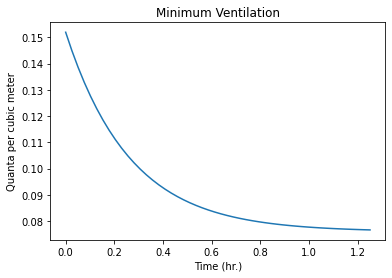

In [9]:
ivrr = .63 + .24 + ach
def quanta_concentration(t, I = n_infected, ERq = ERq1, V = room_dic['room_volume_m'], n0 = 0, IVRR = ivrr):
    return ((ERq * I) / (IVRR * V)) + (n0 + ((ERq * I) / IVRR)) * ((np.e**(-IVRR * t)) / V)

fig = plt.figure()
ax = plt.axes()
plt.xlabel('Time (hr.)')
plt.ylabel('Quanta per cubic meter')
plt.title('Minimum Ventilation')
f2 = np.vectorize(quanta_concentration) 
x = np.linspace(0, t)
ax.plot(x, f2(x));

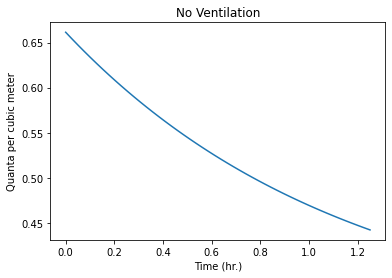

In [10]:
ivrr = .63 + .24
def quanta_concentration(t, I = n_infected, ERq = ERq1, V = room_dic['room_volume_m'], n0 = 0, IVRR = ivrr):
    return ((ERq * I) / (IVRR * V)) + (n0 + ((ERq * I) / IVRR)) * ((np.e**(-IVRR * t)) / V)

fig = plt.figure()
ax = plt.axes()
plt.xlabel('Time (hr.)')
plt.ylabel('Quanta per cubic meter')
plt.title('No Ventilation')
f2 = np.vectorize(quanta_concentration) 
x = np.linspace(0, t)
ax.plot(x, f2(x));

Above we have plotted the quanta concentration over time using minimum ventilation as well as no ventilation at all. 
It is important to note that this model of quanta concentration assumes that the air change will begin at t = 0 so the quanta concentration will continue to decrease over time. This implies the building HVAC system would ventilate in a constant fashion. In reality, HVAC systems tend to work in a cyclical fashion, providing short spurts of air to maintain stable temperatures. Below is an figure from Gupta et al. "Zonal Air Handling in Commercial Buildings" depicting this behavior. 

![title](images/supplyairflow.png)


Finally, to determine the the number of predicted susceptible people infected after the exposure time, we must find the product of the infection risk R and the number of susceptible people. 
To find R, we use the function below
![title](images/formula3.png)

In [3]:

walking_talking_risk = infection_risk(t, 'CENTER 101', 50, 'light_exercise', 'speaking', sys_path + '/data/raw/rm.csv')
sitting_whisper_risk = infection_risk(t, 'CENTER 101', 50, 'resting', 'whispering', sys_path + '/data/raw/rm.csv')
average_risk = (walking_talking_risk + sitting_whisper_risk) /2

The resulting risk of infection is 2.600613699854515%
It is predicted that 0.02600613699854515 x 50 = 1 susceptible occupants will be infected
The resulting risk of infection is 0.021747888350454048%
It is predicted that 0.00021747888350454048 x 50 = 0 susceptible occupants will be infected


In [4]:
infection_risk(t, 'PETER 110', 50, 'light_exercise', 'speaking', sys_path + '/data/raw/rm.csv')


PETER 110 Room height not found. Average room height of 10 ft imputed.
PETER 110 CFM rate not found. California minimum ventilation requirement imputed
The resulting risk of infection is 8.329291151286334%
It is predicted that 0.08329291151286333 x 50 = 4 susceptible occupants will be infected


0.08329291151286333

In [12]:
enablePrint()
print('Average Risk: ' + str(average_risk * 100))
print('Susceptible Occupants Infected: ' + str((int(average_risk * 50))))

We decided to average out the two actions student might engage in in the classroom, those being walking, talking,and sitting and whispering. This produced an average risk of 1.89% with 0 occupants estimated to be infected.
Lets compare this to pre-COVID capcacity...

In [13]:

walking_talking_risk = infection_risk(t, 'CENTER 101', 295, 'light_exercise', 'speaking', sys_path + '/data/raw/rm.csv')
sitting_whisper_risk = infection_risk(t, 'CENTER 101', 295, 'resting', 'whispering', sys_path + '/data/raw/rm.csv')
average_risk = (walking_talking_risk + sitting_whisper_risk) /2

In [14]:
enablePrint()
print('Average Risk: ' + str(average_risk * 100))
print('Susceptible Occupants Infected: ' + str((int(average_risk * 50))))

<BarContainer object of 5 artists>

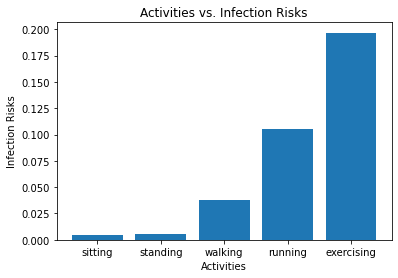

In [15]:
blockPrint()
sitting_talking_risk = infection_risk(t, 'CENTER 101', 50, 'resting', 'speaking', sys_path + '/data/raw/rm.csv')
standing_talking_risk = infection_risk(t, 'CENTER 101', 50, 'standing', 'speaking', sys_path + '/data/raw/rm.csv')
walking_talking_risk = infection_risk(t, 'CENTER 101', 50, 'light_exercise', 'speaking', sys_path + '/data/raw/rm.csv')

running_talking_risk = infection_risk(t, 'CENTER 101', 50, 'moderate_exercise', 'speaking', sys_path + '/data/raw/rm.csv')

exercising_talking_risk = infection_risk(t, 'CENTER 101', 50, 'heavy_exercise', 'speaking', sys_path + '/data/raw/rm.csv')

fig = plt.figure()
ax = plt.axes()
plt.xlabel('Activities')
plt.ylabel('Infection Risks')
plt.title('Activities vs. Infection Risks')
actno = ["sitting", "standing", "walking", "running", "exercising"]
risks = [sitting_talking_risk, standing_talking_risk, walking_talking_risk, running_talking_risk, exercising_talking_risk]
ax.bar(actno, risks)

<BarContainer object of 5 artists>

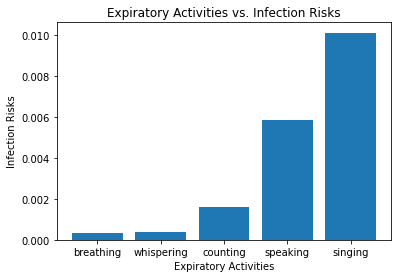

In [16]:
speaking = infection_risk(t, 'CENTER 101', 50, 'standing', 'speaking', sys_path + '/data/raw/rm.csv')
counting = infection_risk(t, 'CENTER 101', 50, 'standing', 'counting', sys_path + '/data/raw/rm.csv')
whispering = infection_risk(t, 'CENTER 101', 50, 'standing', 'whispering', sys_path + '/data/raw/rm.csv')

singing = infection_risk(t, 'CENTER 101', 50, 'standing', 'singing', sys_path + '/data/raw/rm.csv')

breathing = infection_risk(t, 'CENTER 101', 50, 'standing', 'breathing', sys_path + '/data/raw/rm.csv')

fig = plt.figure()
ax = plt.axes()
plt.xlabel('Expiratory Activities')
plt.ylabel('Infection Risks')
plt.title('Expiratory Activities vs. Infection Risks')
actno = ["breathing", "whispering", "counting", "speaking", "singing"]
risks = [breathing, whispering, counting, speaking, singing]
ax.bar(actno, risks)

## Results and Discussion

The purpose of this calculator is to give building users a better understanding of how infection can be spread. Our findings give insight into effective methods for mitigating infection risk in indoor environments. A significant driver in infection risk is the type of physical activity. Heavier breathing increases risk of infection exponentially. Likewise more intense expiratory activity like speaking loudly or singing would increase risk of infection. A large factor in risk mitigation is ventilation. No ventilation at all, we observed, causes a linear decrease in quanta concentration, while minimal ventilation will produce an exponential decrease. 

Unfortunately the effect of social distancing and mask wearing was not directly addressed by this model. Social distancing was indirectly addressed by the assumed 1.5m (>6ft) distance from the emission source in calculating deposition rate. The effect of masks on this model will require further research. 

This Gamaitonni Nucci model is designed to measure the decay in quanta concentration over time models but does not give users a good understanding about the accumulation of quanta concentration and what factors attribute to greater quanta accumulation. 

## Future Work

This model measures the decay in quanta concentration over time well but it does not account for the nature of HVAC systems in buildings. In order to make this algorithm accurate and convenient it should interact more directly with the buildings it is analyzing, meaning that it queries building databases and building metadata to extract real-time and accurate data regarding dimensions, VAV flow capacity, sensor data, etc., in order to more accurately ascribe infection risk to rooms. A large roadblock in the development of this project was access to data regarding building specifications. Additionally, pulling real-time data from the UC San Diego COVID-19 dashboard would add to the validity of this project. 

It is also important for building managers to know the safety threshold for the number of people or the number of hours are allowed in certain rooms. We developed algorithms to estimate it. These are experimental algorithms which requires future development and validations so we include them in future works section. 

#### Calculating max amount of people allowed in room given exposure time & max exposure time given a capacity

In [17]:
# Physical Parameters
room_vol = room_dic['room_volume']
air_exchange_rate = get_air_changes_per_hour(max(room_dic['cfm_range']), room_vol)  # /hr (air changes per hour (ACH))
primary_outdoor_air_fraction = 0.5  # 1.0 = natural ventilation
aerosol_filtration_eff = [0.9997, 0.1, 0]  # HEPA,MERVs,no filter
relative_humidity = 1 - 0.6

In [18]:
#parameters
breathing_flow_rate = 0.5 #meters/hour
max_aerosol_radius = 2 #micrometers
mask_passage_prob = [1,0.3,0.05] #no mask, cloth, N95
exhaled_air_inf = ERq1 * 100 #infection quanta/meter #follow quanta_emission dict to calc
max_viral_deact_rate = 0.6 # per hour
room_vol_m = 0.0283168 * room_vol #meters
mean_ceiling_height_m = 21 * 0.3048 #meters
risk_tolerance = 0.1 #expected transmissions per infector
air_exch_rate = air_exchange_rate #per hour

In [19]:
#calculations
eff_aerosol_radius = ((0.4 / (1 - relative_humidity)) ** (1 / 3)) * max_aerosol_radius
sett_speed_mm = 3 * (eff_aerosol_radius / 5) ** 2 #mm/s
sett_speed = sett_speed_mm * 60 * 60 / 1000  # m/hr
viral_deact_rate = max_viral_deact_rate * relative_humidity
fresh_rate = room_vol * air_exch_rate / 60
recirc_rate = fresh_rate * (1/primary_outdoor_air_fraction - 1)
air_filt_rate = aerosol_filtration_eff[1] * recirc_rate * 60 / room_vol #have to specify which filtration we have
conc_relax_rate = air_exch_rate + air_filt_rate + viral_deact_rate + sett_speed / mean_ceiling_height_m
airb_trans_rate = ((breathing_flow_rate * mask_passage_prob[1]) ** 2) * exhaled_air_inf / (room_vol_m * conc_relax_rate) #have to specify what kind of mask usage

In [20]:
#Calculate maximum people allowed in the room given an exposure time (hours)
#steady state model
def calc_n_max_ss(exp_time): #exp time in hrs
    #risk_tolerance = risk_tolerance  
    n_max = 1 + risk_tolerance / (airb_trans_rate * exp_time)
    return n_max

#transient model
def calc_n_max_t(exp_time): #exp time in hrs
    risk_tolerance = risk_tolerance 
    n_max = 1 + (risk_tolerance * (1 + 1/(conc_relax_rate * exp_time)) / (airb_trans_rate * exp_time))
    return n_max

In [21]:
#Calculate maximum exposure time allowed given a capacity (# people):
def calc_max_time(n_max):
    #risk_tolerance = risk_tolerance

    exp_time_ss = risk_tolerance / ((n_max - 1) * airb_trans_rate)  # hrs, steady-state
    exp_time_trans = exp_time_ss * (1 + (1 + 4 / (conc_relax_rate * exp_time_ss)) ** 0.5) / 2  # hrs, transient
    return exp_time_trans

In [22]:
calc_max_time(750) 

0.015086633369858401